In [1]:
import arc_json_model as ajm
from visualize import ajm_image_show

ajm.Image.show = ajm_image_show

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torchsummary import summary
from tqdm import tqdm


device = torch.device("mps")
#device = torch.device("cuda")
#device = torch.device("cpu")


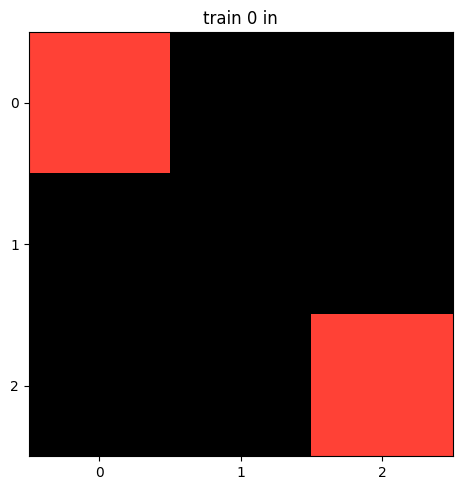

In [83]:
#filename = 'testdata/af902bf9.json'
#filename = 'testdata/62c24649.json'
#filename = 'testdata/a699fb00.json'
#filename = 'testdata/f76d97a5.json'
filename = 'testdata/f5b8619d.json'
task = ajm.Task.load(filename)
image = task.pairs[0].input
image.show()

In [102]:
from color_xy import color_to_xy

# TODO: get it to work with size 30x30
IMAGE_SIZE = 28

def obfuscate_image(image: ajm.Image, offset: float) -> np.ndarray:
    # empty image with size: IMAGE_SIZE x IMAGE_SIZE
    # each pixel is an array with the 2 obfuscated [x,y] values
    rows2 = []
    for y in range(0,IMAGE_SIZE):
        columns2 = [[0.0, 0.0]] * IMAGE_SIZE
        rows2.append(columns2)
    # assign obfuscated values
    for row_index, rows in enumerate(image.pixels):
        for column_index, pixel in enumerate(rows):
            xy = color_to_xy(pixel, 10, offset)
            rows2[row_index][column_index] = xy
    obfuscated_image = np.array(rows2)
    return obfuscated_image

def onehot_image(image: ajm.Image, offset: float) -> np.ndarray:
    offset_int = int(offset * 10.0)
    # empty image with size: IMAGE_SIZE x IMAGE_SIZE
    # each pixel is an array with the 10 values either 0 or 1
    ten_zeros = [0] * 10
    rows2 = []
    for y in range(0,IMAGE_SIZE):
        columns2 = [ten_zeros] * IMAGE_SIZE
        rows2.append(columns2)
    # assign obfuscated values
    for row_index, rows in enumerate(image.pixels):
        for column_index, pixel in enumerate(rows):
            onehot_index = (pixel + offset_int) % 10
            rows2[row_index][column_index][onehot_index] = 1
    obfuscated_image = np.array(rows2)
    return obfuscated_image

def numpy_image_to_tensors(obfuscated_image: np.ndarray, device: torch.device) -> torch.Tensor:
    tensors = torch.from_numpy(obfuscated_image)
    #print(tensors)
    # cast it to 32-bit floating point tensor
    tensors = tensors.type('torch.FloatTensor')
    #print(tensors)
    #print("before", tensors.shape)
    # change layout from: rows -> columns -> obfuscated_pixel_array
    # change layout to:  obfuscated_pixel_array -> rows -> columns
    tensors = tensors.permute(2, 0, 1)
    #print("after", tensors.shape)
    tensors_on_device = tensors.to(device)
    return tensors_on_device
    
all_images = []
for pair in task.pairs:
    all_images.append(pair.input)
    all_images.append(pair.output)

train_input_output = []
test_input_output = []
number_of_offsets = 3
for i in range(0, number_of_offsets):
    offset = float(i) / float(number_of_offsets)
    if i == 0:
        offset = 0.01111
    if i == 1:
        offset = 0.71313
    if i == 2:
        offset = 0.91555
    if i == 3:
        offset = 0.51717
    if i == 4:
        offset = 0.330823
    if i == 5:
        offset = 0.23
    if i == 6:
        offset = 0.893
    
    for pair in task.pairs:
        #input_image = obfuscate_image(pair.input, offset)
        input_image = onehot_image(pair.input, offset)
        #output_image = obfuscate_image(pair.output, offset)
        output_image = onehot_image(pair.output, offset)
        input_tensors = numpy_image_to_tensors(input_image, device)
        output_tensors = numpy_image_to_tensors(output_image, device)
        input_output_offset = (input_tensors, output_tensors, offset)
        if pair.pair_type == ajm.PairType.TRAIN:
            train_input_output.append(input_output_offset)
        else:
            test_input_output.append(input_output_offset)
print("len(train_input_output)", len(train_input_output))
print("len(test_input_output)", len(test_input_output))

len(train_input_output) 9
len(test_input_output) 3


In [103]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 2 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(10, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 10, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)
#summary(model,input_size=(2,30,30))
summary(model,input_size=(10,30,30))
model = model.to(device)

ConvAutoencoder(
  (conv1): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 10, kernel_size=(2, 2), stride=(2, 2))
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]           1,456
         MaxPool2d-2           [-1, 16, 15, 15]               0
            Conv2d-3           [-1, 32, 15, 15]           4,640
         MaxPool2d-4             [-1, 32, 7, 7]               0
   ConvTranspose2d-5           [-1, 16, 14, 14]           2,064
   ConvTranspose2d-6           [-1, 10, 28, 28]             650
Total params: 8,810
Trainable params: 8,810
Non-trainable params: 0
-----------------

In [104]:
# specify loss function
criterion = nn.MSELoss()
#criterion = nn.L1Loss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.KLDivLoss()
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [107]:
import random
#random.Random(42).shuffle(train_input_output)

# number of epochs to train the model
n_epochs = 10

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #random.Random(epoch).shuffle(train_input_output)
    
    ###################
    # train the model #
    ###################
    for input_output_offset in tqdm(train_input_output):
        input, expected_output, _ = input_output_offset
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model

        outputs = model(input)
        # calculate the loss
        loss = criterion(outputs, expected_output)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*input.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_input_output)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 127.24it/s]


Epoch: 1 	Training Loss: 0.748481


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 152.52it/s]


Epoch: 2 	Training Loss: 0.716186


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 172.92it/s]


Epoch: 3 	Training Loss: 0.687404


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 193.68it/s]


Epoch: 4 	Training Loss: 0.661680


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 196.24it/s]


Epoch: 5 	Training Loss: 0.636713


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 189.97it/s]


Epoch: 6 	Training Loss: 0.612834


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 192.99it/s]


Epoch: 7 	Training Loss: 0.588938


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 189.74it/s]


Epoch: 8 	Training Loss: 0.564912


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 185.56it/s]


Epoch: 9 	Training Loss: 0.541787


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 192.00it/s]

Epoch: 10 	Training Loss: 0.519482


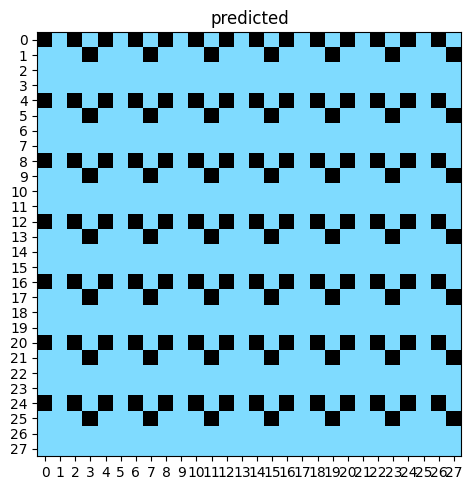

In [108]:
# obtain one batch of test images
dataiter = iter(test_input_output)
input, expected_output, offset = next(dataiter)

# get sample outputs
output = model(input)

output_tensor = output.cpu().detach()
#print("output_tensor.shape", output_tensor.shape)
output_tensor = output_tensor.permute(1, 2, 0)
#print("output_tensor.shape", output_tensor.shape)
output_numpy = output_tensor.numpy()
#print("output_numpy.shape", output_numpy.shape)

from color_xy import xy_to_color

deobfuscated = []
COLOR_UNDEFINED = 10
for y in range(0,IMAGE_SIZE):
    columns2 = [COLOR_UNDEFINED] * IMAGE_SIZE
    deobfuscated.append(columns2)

offset_int = int(offset * 10.0)
for row_index, row in enumerate(output_numpy):
    #print("row_index", row_index)
    for column_index, xy in enumerate(row):
        color_index = np.argmax(xy)
        color_index = (color_index + 10 - offset_int) % 10
        deobfuscated[row_index][column_index] = color_index
        #x, y = xy
        #distance = x * x + y * y
        #if distance > 0.35 and distance < 1.5:
        #    color = xy_to_color((x, y), 10, offset)
        #    deobfuscated[row_index][column_index] = color

pixels = np.array(deobfuscated, np.int32)
result = ajm.Image(pixels, "predicted")
result.show()